# HDBSCAN Clustering + Advanced Retrieval (RAG-style) Assignment

This notebook has two parts:

**Part 1:** HDBSCAN Clustering — Deep Dive into Algorithm Internals  
**Part 2:** Advanced Retrieval Systems and RAG (Retrieval-Augmented Generation)

Because I do not have an external LLM API key, the “generation” part is implemented as an **extractive answer** built from retrieved chunks, which still demonstrates the full retrieval pipeline.

In [1]:
!pip -q install hdbscan umap-learn sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 73.1 MB/s eta 0:00:00


In [2]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import umap
import hdbscan
import faiss

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style="whitegrid")
np.random.seed(42)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## Part 1: HDBSCAN Clustering — Deep Dive into Algorithm Internals

### 1.1 Load and Prepare the Dataset
We load the CSV and create a single text field by combining `title` and `content`.  
This is common in text clustering because titles are short but informative, while content provides additional context.

In [3]:
DATA_PATH = "/content/combined_data_environment.csv"

df = pd.read_csv(
    DATA_PATH,
    sep=";",
    encoding="latin1",
    engine="python",
    on_bad_lines="skip"
)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (2969, 15)
Columns: ['title', 'publication_date', 'byline', 'content', 'subject', 'country', 'city', 'person', 'industry', 'company', 'word_count', 'publication_date_text', 'publication', 'author', 'copyright']


,title,publication_date,byline,content,subject,country,city,person,industry,company,word_count,publication_date_text,publication,author,copyright
0,Egypt at the forefront of developing green and...,01.01.22,NaN,Egypt at the forefront of developing green and...,"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...","['EGYPT', 'AFRICA', 'MIDDLE EAST', 'NORTHERN A...","['GLASGOW, SCOTLAND']",[],"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...",[],1827,Jan 22,['Euromoney'],NaN,Copyright 2022 Euromoney Institutional Investo...
1,"Inequality, climate change and economic recove...",29.11.21,FinTech Futures,"Inequality, climate change and economic recove...","['CLIMATE CHANGE', 'GREEN FINANCE', 'ECONOMIC ...","['AFRICA', 'SOUTH AFRICA', 'EASTERN AFRICA', '...",[],[],"['SIC6021 NATIONAL COMMERCIAL BANKS', 'GREEN F...",['AFRICAN DEVELOPMENT BANK GROUP'],699,"November 29, 2021 Monday",['Fintechfutures.com'],FinTech Futures,Copyright 2021 Informal PLC All Rights Reserved
2,11th UK-India Economic and Financial Dialogue ...,02.09.21,NaN,11th UK-India Economic and Financial Dialogue ...,"['PUBLIC FINANCE', 'COVID CORONAVIRUS', 'COVID...","['UNITED KINGDOM', 'INDIA', 'BRICS MEMBER STAT...","['LONDON, ENGLAND']",[],"['PUBLIC FINANCE AGENCIES & TREASURIES', 'TREA...",[],3560,"September 2, 2021 Thursday",['Impact News Service'],NaN,Copyright 2021 Impact Media Limited All Rights...
3,"""Being the Change We Want to See: A Sustainabl...",09.06.21,NaN,"""Being the Change We Want to See: A Sustainabl...","['SUSTAINABILITY', 'SUSTAINABLE DEVELOPMENT', ...","['SINGAPORE', 'ASIA', 'UNITED STATES']",[],[],"['SUSTAINABLE DEVELOPMENT', 'EMISSIONS', 'BANK...",[],3693,"June 9, 2021 Wednesday",['Singapore Government News'],NaN,"Copyright 2021 Singapore Government News, dist..."
4,Together we can mobilise capital and achieve n...,11.01.22,AXEL A. WEBER,Together we can mobilise capital and achieve n...,"['SUSTAINABLE DEVELOPMENT', 'AGREEMENTS', 'CLI...","['CHINA', 'UNITED STATES', 'ASIA', 'EUROPE']",[],[],"['SUSTAINABLE DEVELOPMENT', 'BANKING & FINANCE...",[],1004,"January 11, 2022 Tuesday",['The Australian'],AXEL A. WEBER,Copyright 2022 Nationwide News Pty Limited All...


In [4]:
def clean_text(x):
    x = "" if pd.isna(x) else str(x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df["title_clean"] = df["title"].apply(clean_text) if "title" in df.columns else ""
df["content_clean"] = df["content"].apply(clean_text) if "content" in df.columns else ""

df["text"] = (df["title_clean"] + ". " + df["content_clean"]).str.strip()
df = df[df["text"].str.len() > 30].copy()   # remove very tiny/empty rows
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("After cleaning:", df.shape)
df[["title_clean","text"]].head()

After cleaning: (2856, 18)


,title_clean,text
0,Egypt at the forefront of developing green and...,Egypt at the forefront of developing green and...
1,"Inequality, climate change and economic recove...","Inequality, climate change and economic recove..."
2,11th UK-India Economic and Financial Dialogue ...,11th UK-India Economic and Financial Dialogue ...
3,"""Being the Change We Want to See: A Sustainabl...","""Being the Change We Want to See: A Sustainabl..."
4,Together we can mobilise capital and achieve n...,Together we can mobilise capital and achieve n...


### 1.2 Create Embeddings
HDBSCAN works on numeric vectors. For text, we first convert documents into dense vectors (“embeddings”).  
We use a pretrained `SentenceTransformer` model (`all-MiniLM-L6-v2`) because it is fast and works well for semantic similarity.

In [5]:
# To finish within 1 hour, use a subset (you can increase later if time allows)
N = min(1000, len(df))
df_small = df.sample(n=N, random_state=42).reset_index(drop=True)

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_small["text"].tolist(), show_progress_bar=True, normalize_embeddings=True)

embeddings = np.array(embeddings).astype("float32")
print("Embeddings shape:", embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Embeddings shape: (1000, 384)


### 1.3 Dimensionality Reduction (UMAP)
HDBSCAN can work in high dimensions, but it often performs better after reducing dimensionality.
UMAP preserves local structure and helps clustering + visualization.

In [6]:
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=5,   # 5D for clustering stability
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

emb_umap = reducer.fit_transform(embeddings)
emb_umap = emb_umap.astype("float32")
print("UMAP shape:", emb_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (1000, 5)


### 1.4 Run HDBSCAN
HDBSCAN is a density-based clustering algorithm.
Key parameters:
- `min_cluster_size`: smallest cluster size allowed
- `min_samples`: how strict density should be (higher = more noise points)

In [7]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=5,
    metric="euclidean",
    prediction_data=True
)

labels = clusterer.fit_predict(emb_umap)
df_small["cluster"] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)
df_small["cluster"].value_counts().head(10)

Clusters found: 16
Noise points: 276


,count
cluster,
-1,276
0,129
15,128
13,63
10,60
2,54
9,47
7,36
5,35


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


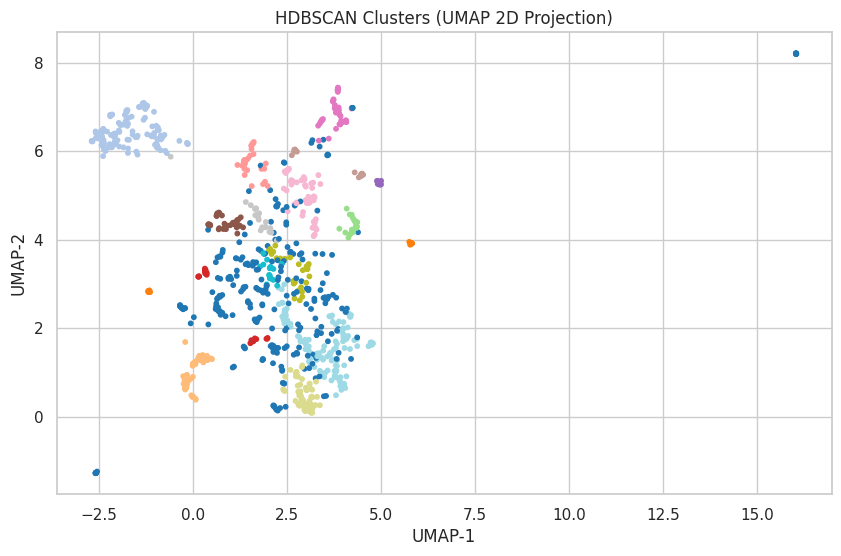

In [8]:
reducer_2d = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric="cosine", random_state=42)
emb_2d = reducer_2d.fit_transform(embeddings)

plt.figure(figsize=(10,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap="tab20", s=10)
plt.title("HDBSCAN Clusters (UMAP 2D Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

### 1.5 Algorithm Internals (Deep Dive)

HDBSCAN builds clusters using a density-based idea:

1. **Core distance**: distance from a point to its k-th nearest neighbor (controls local density).
2. **Mutual reachability distance** between points *a* and *b*:
   - max(core_dist(a), core_dist(b), dist(a,b))
   This makes sparse areas “farther apart” and dense areas “closer”.
3. Using mutual reachability, HDBSCAN constructs a **minimum spanning tree (MST)** and then forms a hierarchy.
4. Clusters are selected based on **stability** over different density levels (condensed tree).

Below we visualize the condensed tree which represents the cluster hierarchy and stability.

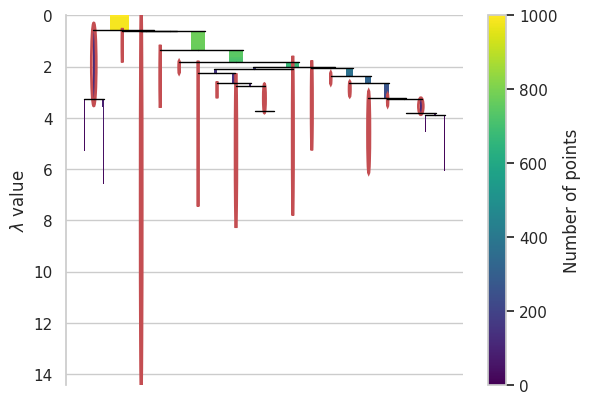

In [9]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

### 1.6 Interpret Clusters (Top Keywords)
To understand what each cluster represents, we extract top TF‑IDF keywords from documents within each cluster.
This helps explain the “theme” of each group.

In [10]:
def top_keywords_for_cluster(texts, top_n=8):
    vec = TfidfVectorizer(stop_words="english", max_features=3000)
    X = vec.fit_transform(texts)
    avg = np.asarray(X.mean(axis=0)).ravel()
    idx = avg.argsort()[::-1][:top_n]
    return [vec.get_feature_names_out()[i] for i in idx]

clusters = sorted([c for c in df_small["cluster"].unique() if c != -1])

for c in clusters[:5]:  # show first 5 clusters (fast)
    texts_c = df_small.loc[df_small["cluster"] == c, "text"].tolist()
    print(f"\nCluster {c} | size={len(texts_c)}")
    print("Top keywords:", top_keywords_for_cluster(texts_c, top_n=10))
    print("Example title:", df_small.loc[df_small["cluster"] == c, "title_clean"].iloc[0])


Cluster 0 | size=129
Top keywords: ['sustainable', 'finance', 'uae', 'adgm', 'climate', 'financial', 'dhabi', 'abu', 'difc', 'sustainability']
Example title: ADIB Announces Associate Pathway Partnership with COP28

Cluster 1 | size=17
Top keywords: ['pnc', 'wells', 'fargo', 'sustainable', 'finance', 'environmental', '2018', 'loans', 'climate', 'low']
Example title: PNC Pledges $20 Billion In Environmental Finance

Cluster 2 | size=54
Top keywords: ['sustainable', 'canada', 'finance', 'climate', 'bmo', 'financial', 'panel', 'green', 'report', 'bank']
Example title: Canada's central climate bank; Terence corcoran

Cluster 3 | size=24
Top keywords: ['sustainable', 'finance', 'g20', 'india', 'ifsca', 'meeting', 'financial', 'global', 'ceew', 'climate']
Example title: International Financial Services Centres Authority (IFSCA) and Climate Policy Initiative sign MoU to cooperate on Sustainable Finance

Cluster 4 | size=23
Top keywords: ['sustainable', 'bbva', 'finance', 'bank', 'nordea', 'me

## Part 2: Advanced Retrieval Systems and RAG

### 2.1 Chunk Documents
Retrieval works better on smaller text chunks rather than entire long articles.
We will split each document into overlapping chunks.

In [11]:
def chunk_text(text, chunk_size=400, overlap=80):
    words = text.split()
    chunks = []
    step = chunk_size - overlap
    for i in range(0, len(words), step):
        chunk = " ".join(words[i:i+chunk_size])
        if len(chunk.split()) >= 30:
            chunks.append(chunk)
    return chunks

chunks = []
meta = []

for i, row in df_small.iterrows():
    doc_chunks = chunk_text(row["text"])
    for j, ch in enumerate(doc_chunks):
        chunks.append(ch)
        meta.append({"doc_id": i, "chunk_id": j, "title": row.get("title_clean","")})

print("Total chunks:", len(chunks))
print("Example chunk:\n", chunks[0][:400])

Total chunks: 3682
Example chunk:
 ADIB Announces Associate Pathway Partnership with COP28. ADIB Announces Associate Pathway Partnership with COP28 Abu Dhabi Islamic Bank (ADIB) has announced its partnership as an Associate Pathway Partner of the 28th United Nations Climate Change Conference (COP28). ADIB will showcase how financial institutions can enable progress toward sustainability goals and support the UAE's development as a 


### 2.2 Build Vector Index (FAISS)
We embed each chunk and store the vectors in a FAISS index.  
FAISS allows fast approximate nearest neighbor search (vector similarity search).

In [12]:
chunk_emb = model.encode(chunks, show_progress_bar=True, normalize_embeddings=True)
chunk_emb = np.array(chunk_emb).astype("float32")

dim = chunk_emb.shape[1]
index = faiss.IndexFlatIP(dim)   # inner product (works with normalized embeddings = cosine similarity)
index.add(chunk_emb)

print("FAISS index size:", index.ntotal)

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

FAISS index size: 3682


### 2.3 Retrieval (Top-k)
Given a user query, we embed it and retrieve the most similar chunks from FAISS.
We print the retrieved chunks and similarity scores.

In [13]:
def retrieve(query, k=5):
    q_emb = model.encode([query], normalize_embeddings=True).astype("float32")
    scores, idxs = index.search(q_emb, k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        results.append((float(score), meta[idx], chunks[idx]))
    return results

query = "green finance and renewable energy projects"
results = retrieve(query, k=5)

for score, m, ch in results:
    print("\nScore:", round(score, 3), "| doc:", m["doc_id"], "| chunk:", m["chunk_id"])
    print("Title:", m["title"][:120])
    print("Chunk preview:", ch[:400])


Score: 0.696 | doc: 696 | chunk: 1
Title: Canada: Canada issues inaugural green bond
Chunk preview: government investments in green infrastructure, renewable energy, nature conservation and other environmental initiatives. This and the ones to come will broaden the market for highly rated green investment opportunities and strengthen sustainable finance in Canada, which in turn will help finance projects to fight climate change and protect the environment. - The Honourable Randy Boissonnault, Mi

Score: 0.696 | doc: 151 | chunk: 4
Title: Sustainable finance's biggest problems, by the people who know best
Chunk preview: to get funded. "You need only look at the slim amount of green-bond issuance in emerging markets to know green finance is not helping a change." According to the International Capital Markets Association (Icma), emerging markets issuance accounts for about a quarter of all green-bond issuance to date. "Are we truly creating additionality with green bonds?" asks another 

### 2.4 RAG-style Answer Generation (No API Key)
In a full RAG system, we would pass retrieved chunks into an LLM to generate an answer.
Since no API key is available, we implement a **simple extractive generator**:
- retrieve top-k chunks
- return the most relevant sentences from those chunks
This still demonstrates the retrieval + context injection workflow.

In [14]:
import nltk
nltk.download("punkt")

from nltk.tokenize import sent_tokenize

def rag_answer(query, k=5, max_sentences=5):
    retrieved = retrieve(query, k=k)
    all_text = " ".join([ch for _, _, ch in retrieved])
    sentences = sent_tokenize(all_text)

    # rank sentences by TF-IDF similarity to query (simple student baseline)
    vec = TfidfVectorizer(stop_words="english")
    X = vec.fit_transform([query] + sentences)
    sims = (X[0] @ X[1:].T).toarray().ravel()

    top_idx = sims.argsort()[::-1][:max_sentences]
    answer = " ".join([sentences[i] for i in top_idx])
    return answer, retrieved

q2 = "What does the dataset say about climate change and sustainable finance?"
answer, retrieved = rag_answer(q2, k=6, max_sentences=5)

print("QUESTION:", q2)
print("\nANSWER (extractive RAG-style):\n", answer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
